# Download Spark (I'm using 3.0.1)

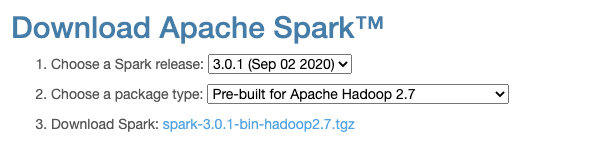

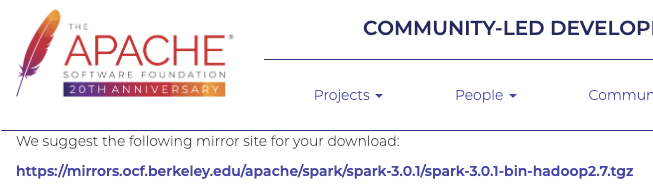

# Move & Unpack

In [ ]:
# Move from Downloads to Desktop
# !mv ~/Downloads/spark-3.0.1-bin-hadoop2.7.tgz

# Unpack on desktop
# !tar -xvzf spark-3.0.1-bin-hadoop2.7

# Update bash_profile settings
1. !nano ~/.bash_profile
1. ***Put in variables as below***
1. !source ~/.bash_profile
* Typing "pyspark" automatically opens up a jupyter lab environment configured with pyspark rather than working in terminal

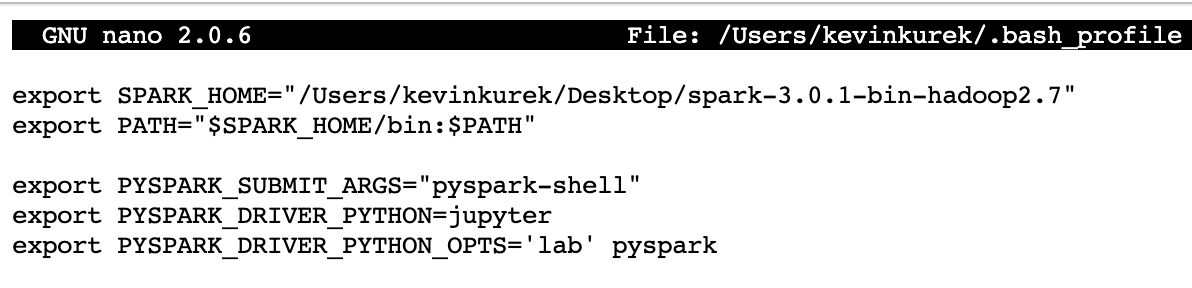

In [2]:
# export SPARK_HOME="/Users/kevinkurek/Desktop/spark-3.0.1-bin-hadoop2.7"
# export PATH="$SPARK_HOME/bin:$PATH"

# export PYSPARK_SUBMIT_ARGS="pyspark-shell"
# export PYSPARK_DRIVER_PYTHON=jupyter
# export PYSPARK_DRIVER_PYTHON_OPTS='lab' pyspark

In [1]:
# Testing Configuration worked
sc

<SparkContext master=local[*] appName=PySparkShell>

# Basic RDD functionality

In [4]:
from pyspark.sql.types import Row
from datetime import datetime

In [5]:
# Basic Python List
python_list = [1, "Kevin", 28]

# Convert Python list to a Spark RDD
simple_data = sc.parallelize(python_list)
simple_data.count() # count() is an "action" that does actual computation in spark (expensive to run on large data)

3

# Basic Spark RDD to Spark DF (NOT Pandas DF)

In [12]:
# Pass RDD with explicit Row names prior to .toDF()
data = sc.parallelize([Row(id=1, name='Kevin', score=50),
                          Row(id=2, name='Tom', score=25)])
df = data.toDF()
df.show()

+---+-----+-----+
| id| name|score|
+---+-----+-----+
|  1|Kevin|   50|
|  2|  Tom|   25|
+---+-----+-----+



# Using Spark Dataframe API

In [1]:
# Entry point into Spark Application
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("Analyzing Crime Data").getOrCreate()

In [4]:
data = spark.read\
            .format("csv")\
            .option("header", "true")\
            .load("/Users/kevinkurek/Desktop/GitHub/spark/data/london_crime_by_lsoa.csv")

In [7]:
display(data.count())
data.printSchema()

13490604

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)



In [8]:
data.limit(5).show()

+---------+----------+--------------------+--------------------+-----+----+-----+
|lsoa_code|   borough|      major_category|      minor_category|value|year|month|
+---------+----------+--------------------+--------------------+-----+----+-----+
|E01001116|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+---------+----------+--------------------+--------------------+-----+----+-----+



In [9]:
# Just like Pandas .dropna() method
data.dropna()

DataFrame[lsoa_code: string, borough: string, major_category: string, minor_category: string, value: string, year: string, month: string]

In [10]:
# Just like Pandas .drop() method
data = data.drop("lsoa_code")
data.show(5)

+----------+--------------------+--------------------+-----+----+-----+
|   borough|      major_category|      minor_category|value|year|month|
+----------+--------------------+--------------------+-----+----+-----+
|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+----------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [13]:
# Filter like Pandas df[(df['year'].isin(["2014", "2015"])) & (df['minor_category']=='Personal_Property')]
year_2014_df = data.filter((data['year'].isin(["2014", "2015"])) 
                           & (data['minor_category']=='Personal Property'))
year_2014_df.show(5)

+--------------------+--------------+-----------------+-----+----+-----+
|             borough|major_category|   minor_category|value|year|month|
+--------------------+--------------+-----------------+-----+----+-----+
|Richmond upon Thames|       Robbery|Personal Property|    0|2014|    1|
|              Ealing|       Robbery|Personal Property|    0|2015|    7|
|             Bromley|       Robbery|Personal Property|    0|2014|    6|
|              Ealing|       Robbery|Personal Property|    0|2014|    9|
|Kensington and Ch...|       Robbery|Personal Property|    1|2015|    7|
+--------------------+--------------+-----------------+-----+----+-----+
only showing top 5 rows



In [18]:
# Groupby & Renaming
borough_conviction_sum = data.groupBy("Borough")\
                             .agg({"value": "sum"})\
                             .withColumnRenamed("sum(value)", "convictions")
borough_conviction_sum.show(5)

# Find total by summing convictions
total_borough_convictions = borough_conviction_sum.agg({"convictions":"sum"})
total_borough_convictions.show()

# Access actual value in DF of convictions total
total_convictions = total_borough_convictions.collect()[0][0]

+--------------------+-----------+
|             Borough|convictions|
+--------------------+-----------+
|             Croydon|   260294.0|
|          Wandsworth|   204741.0|
|              Bexley|   114136.0|
|             Lambeth|   292178.0|
|Barking and Dagenham|   149447.0|
+--------------------+-----------+
only showing top 5 rows

+----------------+
|sum(convictions)|
+----------------+
|       6447758.0|
+----------------+



In [30]:
from pyspark.sql.types import IntegerType

# Monthly Convictions
conviction_monthly = data.filter(data["year"]==2014)\
                            .groupBy("month")\
                            .agg({"value":"sum"})\
                            .withColumnRenamed("sum(value)", "convictions")

# Total monthly convictions
total_convictions_monthly = conviction_monthly.agg({"convictions":"sum"}).collect()[0][0]

# Pct Monthly Conviction Column
total_convictions_monthly = conviction_monthly.withColumn(
                                    "percent", 
                                    func.round(conviction_monthly['convictions'] / total_convictions_monthly * 100, 2))

# Currently "month" col is a string, convert to int
total_convictions_monthly = total_convictions_monthly.withColumn("month", 
                                                                    total_convictions_monthly['month'].cast(IntegerType()))

# orderBy Month
total_convictions_monthly.orderBy(total_convictions_monthly["month"].asc()).show()

+-----+-----------+-------+
|month|convictions|percent|
+-----+-----------+-------+
|    1|    55515.0|   8.16|
|    2|    51222.0|   7.53|
|    3|    57669.0|   8.48|
|    4|    53467.0|   7.86|
|    5|    56327.0|   8.28|
|    6|    57039.0|   8.39|
|    7|    58564.0|   8.61|
|    8|    55641.0|   8.18|
|    9|    56933.0|   8.37|
|   10|    60537.0|    8.9|
|   11|    59704.0|   8.78|
|   12|    57565.0|   8.46|
+-----+-----------+-------+



In [37]:
# Using Crosstab & selecting few columns
crosstab = data.crosstab("borough", "major_category")\
            .select("borough_major_category", "Burglary", "Drugs", "Robbery")

crosstab.orderBy(crosstab["Drugs"].desc()).show()

+----------------------+--------+-----+-------+
|borough_major_category|Burglary|Drugs|Robbery|
+----------------------+--------+-----+-------+
|               Croydon|   47520|51948|  43740|
|                Ealing|   42336|50220|  37908|
|               Lambeth|   38448|48060|  37908|
|                Barnet|   45576|47412|  39528|
|                 Brent|   37368|46980|  34128|
|             Southwark|   35856|45144|  35316|
|               Enfield|   39528|44064|  35532|
|              Lewisham|   36504|43740|  34884|
|               Bromley|   42552|42336|  34668|
|            Wandsworth|   38664|41904|  36072|
|                Newham|   35424|41580|  34452|
|               Hackney|   31104|38772|  29160|
|            Hillingdon|   34776|37584|  29808|
|         Tower Hamlets|   31104|37368|  28512|
|             Greenwich|   32616|37260|  30240|
|             Redbridge|   34776|36504|  32400|
|              Haringey|   31320|35424|  29484|
|        Waltham Forest|   31104|34884| 

In [51]:
# Convert from Spark DF to Pandas DF
pandas_df = crosstab.toPandas()
pandas_df.head(5)

,borough_major_category,Burglary,Drugs,Robbery
0,Havering,32400,32616,27648
1,Merton,26784,29160,23652
2,Haringey,31320,35424,29484
3,Tower Hamlets,31104,37368,28512
4,Bromley,42552,42336,34668


In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [49]:
def describe_year(year):
    
    # Spark Transformations
    yearly_details = data.filter(data.year == year)\
                            .groupBy("borough")\
                            .agg({"value":"sum"})\
                            .withColumnRenamed("sum(value)","convictions")
    
    # Use toLocalIterator() method to grab borough and conviction by year
    borough_list = [x[0] for x in yearly_details.toLocalIterator()]
    convictions_list = [x[1] for x in yearly_details.toLocalIterator()]
    
    plt.figure(figsize=(33, 10))
    plt.bar(borough_list, convictions_list)
    
    plt.title("Crime for the year: " + year, fontsize=30)
    plt.xlabel("Boroughs", fontsize=30)
    plt.ylabel("Convictions", fontsize=30)
    
    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.autoscale()
    plt.show()

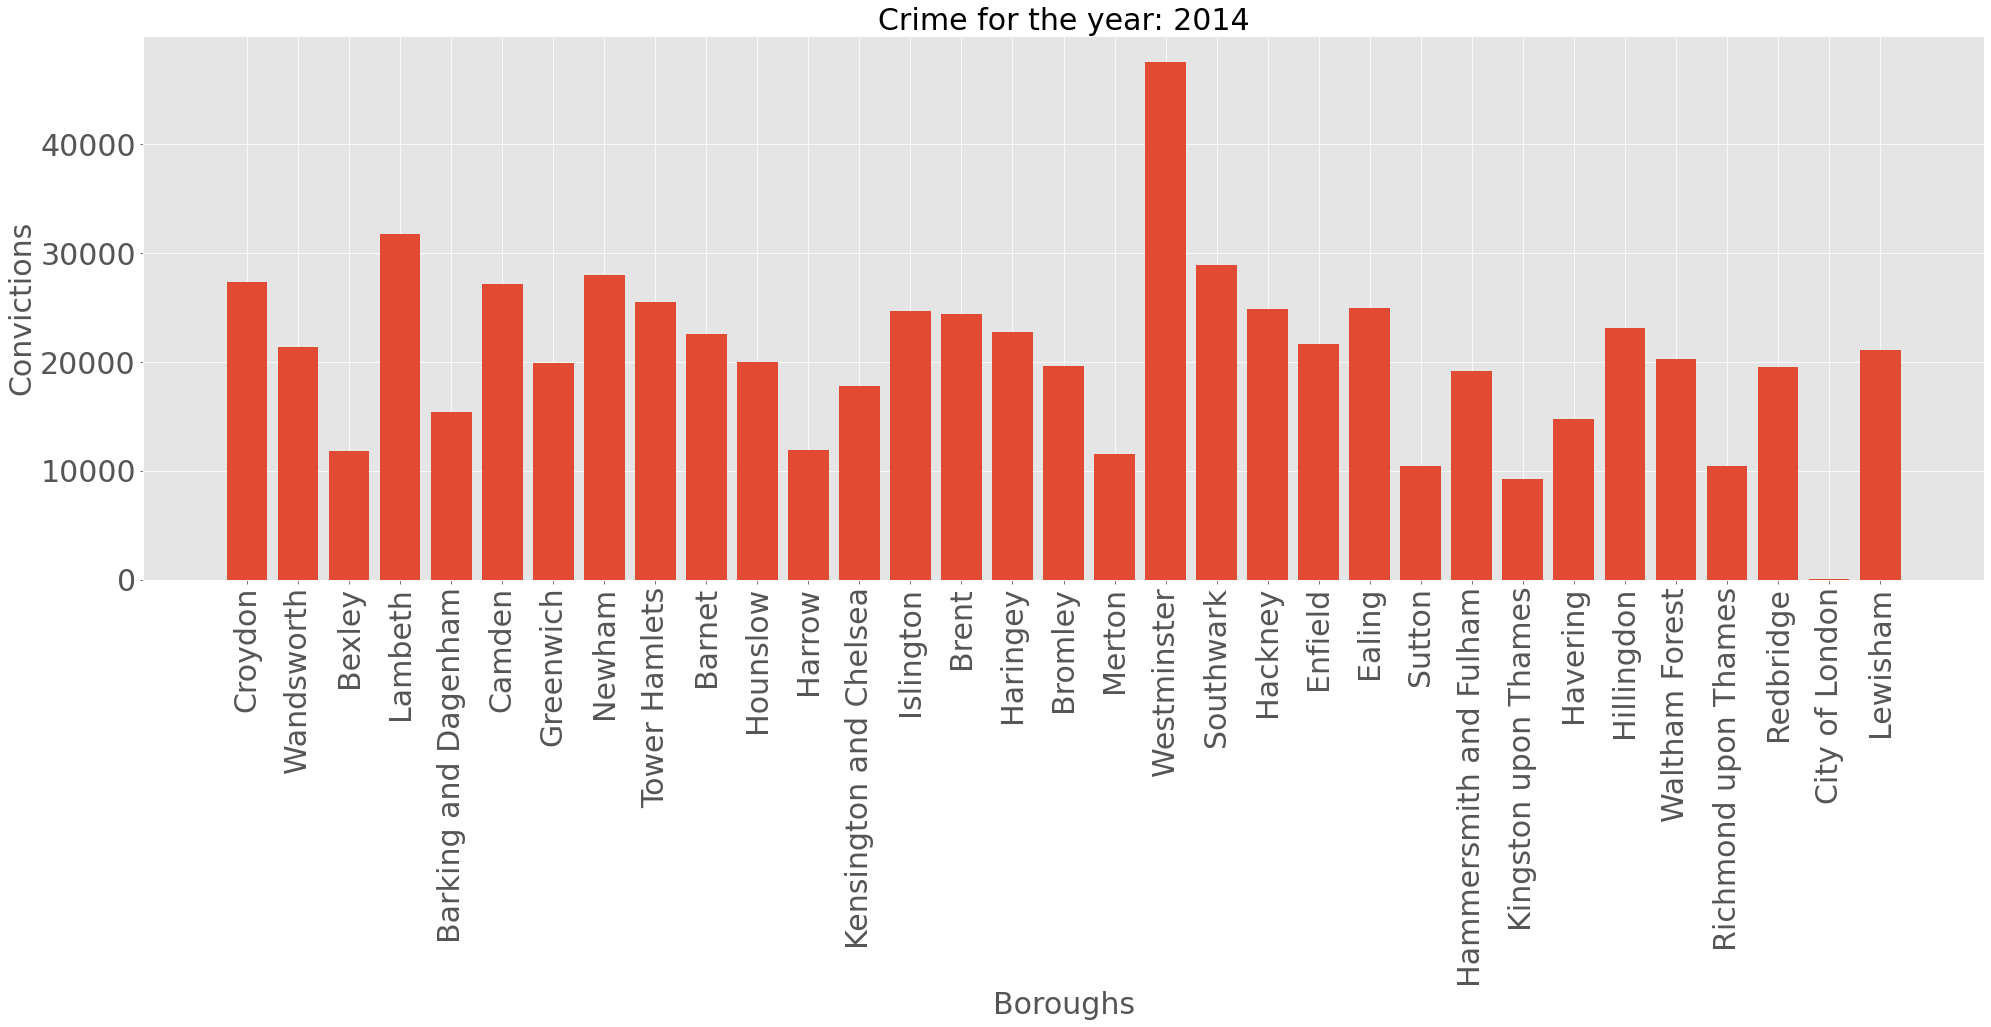

In [50]:
describe_year("2014")